# Chorus Effect

In this notebook we will implement a very simple Chorus effect. A chorus effect in its purest form is simply a modulated delay line. Thus we first need to define a delay line and a modulator.

First we start importing the necessary libraries. 

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
import ipywidgets as widgets
from scipy.io import wavfile


# 1. Creating a delay line 

We'will start by creating a class for which we'll be able to take samples from the past at any position we like. 
For this we need a way to interpolate values of between samples, so we're not restricted by the sampling rate. 
For this, we will implement a simple linear interpolation, however cubic or sinc interpolations tend to produce better results (with less aliasing).

Obs: Some plugins intentionally use some specific types of interpolations only because of how they sound. 

In [12]:
class Interpolator:
    def interpolate(self, x1, y1, x2, y2, x):
        return 0 

class LinearInterpolator(Interpolator):
    def interpolate(self, delay_line:np.array,delay_in_samples:float):
        x  = delay_in_samples
        x1 = int( np.floor(delay_in_samples) )
        x2 = int( np.ceil(delay_in_samples) )
 
        y1 = delay_line[x1]
        y2 = delay_line[x2]
 
        return y1 + (x - x1) * (y2 - y1) / (x2 - x1+1e-10)   
        
class DelayLine:
    maximum_length:int=20000
    delay_line:np.array
    _pointer:int = 0
    interpolator:Interpolator 
    sampling_rate:int 
    def __init__(self,maximum_length:int,
             sampling_rate:float=48000,
             interpolator:Interpolator= LinearInterpolator()):

        self.maximum_length = maximum_length
        self.delay_line = np.zeros(maximum_length)
        self.interpolator = interpolator
        self.sampling_rate = sampling_rate
    def reset(self):
        self._pointer = 0
    def _increase_pointer(self):
        self._pointer += 1
        self._pointer = self._pointer%(self.maximum_length-1) # In C++ you can use a trick with the wire-anding operator to make this faster: "pointer &= maximum_length-1"
    def append_value(self,value):
        self._increase_pointer()
        self.delay_line[self._pointer] = value 
        
    
    def get_value_at_delay_ms(self,delay_in_ms:float):
        delay_in_samples = delay_in_ms/1000.*self.sampling_rate
        assert delay_in_samples<self.maximum_length, 'delay time of '+str(delay_in_samples) +' above maximum length of '+str(self.maximum_length)+'. Either reduce it or increase the buffer length'
        
        tolerance_for_integer = 1e-3
        if delay_in_samples-int(delay_in_samples)<tolerance_for_integer:
            return self.get_value_at_delay_integer_samples(int(delay_in_samples))
        
        delay_position = (self._pointer - delay_in_samples) % (self.maximum_length-1)
        return self.interpolator.interpolate(self.delay_line,delay_position)
    
    def get_value_at_delay_integer_samples(self,delay_samples:int):
        assert delay_samples == int(delay_samples), 'delay time must be an integer'
        idx_of_sample = (self._pointer - delay_samples) % (self.maximum_length-1)
        return self.delay_line[idx_of_sample]
        

        

Now we can test our delay

In [13]:
sampling_rate = 48000
time = np.linspace(0,1,sampling_rate)
signal = np.sin(2*np.pi*10*time)

@widgets.interact(delay=(0, 100))
def f(delay=21):
    delay_signal = np.zeros_like(signal)
    delay_line = DelayLine(maximum_length=20000,sampling_rate=sampling_rate)
    for idx,val in enumerate(signal):
        delay_line.append_value(val)
        delay_signal[idx] = delay_line.get_value_at_delay_ms(delay)


    plt.plot(time,signal)
    plt.plot(time,delay_signal)
    plt.legend(['Original','Delay'])
    plt.xlabel('time [s]')
    plt.ylabel('amp')
    plt.show()

interactive(children=(IntSlider(value=21, description='delay'), Output()), _dom_classes=('widget-interact',))

# 2. Creating a LFO 

Now we create a routine to generate a simple sinusoidal LFO (Low-Frequency-Oscillator). You can expand it and add any type you want. 

In [5]:
class LFO:
    frequency:float
    amplitude:float
    sampling_rate:float
    _dt:float
    _step:int
    base_value:float
    def __init__(self,frequency:float,amplitude:float=1,base_value:float=0,sampling_rate:float=48000): 
        self._dt = 1./sampling_rate
        self._step=0
        self.sampling_rate=sampling_rate
        self.frequency=frequency
        self.base_value= base_value
        self.amplitude = amplitude
        
    def get_value(self):
        return 0

    def update_step(self):
        self._step += 1
        self._step = self._step%(self.sampling_rate/self.frequency)

class SineLFO(LFO):
    def get_value(self):
        self.update_step()
        lfo_sample = self.amplitude*np.sin(2*np.pi*self.frequency*self._dt*self._step)+self.base_value
        return lfo_sample

# Challenge: Can you finish the following class?
#class TriangleLFO(LFO):
#    def get_value(self):
#        self.update_step()
#        # YOUR CODE! 
#        lfo_sample =  
#        return lfo_sample

Again we test our implementation

In [6]:
amp_slider = widgets.FloatSlider(
    value=1.,
    min=0.,
    max=1.0,
    step=0.1,
    description='amplitude:',
    readout_format='.1f',
)

base_slider = widgets.FloatSlider(
    value=0.,
    min=-1.0,
    max=1.0,
    step=0.1,
    description='base value:',
    readout_format='.1f',
)

@widgets.interact(frequency=(1, 30),amplitude=amp_slider,base_value=base_slider)
def f(frequency=10,amplitude=1,base_value=0):
    lfo_signal = np.zeros(48000)

    LFO = SineLFO(frequency=frequency,amplitude=amplitude,base_value=base_value,sampling_rate=48000)
    for idx,val in enumerate(lfo_signal):
        lfo_signal[idx] = LFO.get_value()
    plt.plot(lfo_signal)
    plt.ylim(-2,2)
    plt.show()

interactive(children=(IntSlider(value=10, description='frequency', max=30, min=1), FloatSlider(value=1.0, desc…

# 3. Create the Chorus effect

Now that we have defined the delay line and the LFO, we can merge then together to implement the Chorus effect.

We do this by modulating the delay line with our LFO.

In [7]:
class Chorus:
    delay_line:DelayLine
    lfo:LFO
    wet_factor:float 
    dry_factor:float
    feedback:float 
    def __init__(self,delay_line:DelayLine,lfo:LFO,feedback:float=0.1,dry_factor_dB:float=-3,wet_factor_dB:float=-6) -> None:
        self.delay_line = delay_line
        self.lfo = lfo
        self.feedback = feedback
        self.set_dry_wet_factor_dB(dry_factor_dB,wet_factor_dB)
        
    def process_sample(self,sample):

        
        delayed_sample= self._get_current_delay_value()
        delay_line_value= sample+delayed_sample*self.feedback
        self.delay_line.append_value(delay_line_value)
        
        processed_sample = delayed_sample
        output = sample*self.dry_factor + processed_sample*self.wet_factor

        self.delay_line.append_value(sample)

        return output

    def set_dry_wet_factor_dB(self,dry_factor_dB:float,wet_factor_dB:float):
        self.dry_factor = 10**(dry_factor_dB/20)
        self.wet_factor = 10**(wet_factor_dB/20)

    def _get_current_delay_value(self):
        delay_value_ms = self.lfo.get_value()
        assert delay_value_ms > 0 , 'delay value must be positive. You probably used a amplitude higher than the base value in the lfo'
        return self.delay_line.get_value_at_delay_ms(delay_value_ms)


Now we can load a recording and test our chorus effect! 

In [8]:
def load_and_scale_wav_file(filename:str,scaling_factor:float=0.2):
    sampling_rate, signal = wavfile.read(filename)
    signal = signal[:,0]/np.max(signal[:,0]) # We do it only for one channel here, feel free to expand it
    signal *= scaling_factor
    return sampling_rate,signal


sampling_rate, signal = load_and_scale_wav_file('testForChorus.wav')


delay_line = DelayLine(maximum_length=20000,sampling_rate=sampling_rate)
lfo = SineLFO(frequency=0.3,amplitude=14,base_value=15,sampling_rate=48000)
processor = Chorus(delay_line,lfo,feedback=0.2)

/var/folders/k6/0k6bxfs50l1d4jnvnk3d2yp00000gn/T/ipykernel_87035/2132789362.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, signal = wavfile.read(filename)


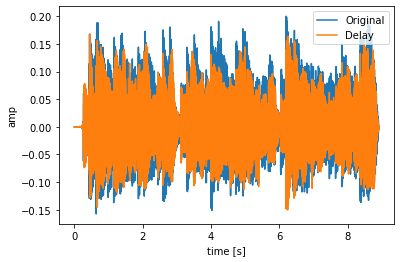

In [9]:
chorus_signal = np.zeros_like(signal)
for idx,val in enumerate(signal):
    chorus_signal[idx] = processor.process_sample(val)


time = np.linspace(0,len(signal)/sampling_rate,len(signal))
plt.plot(time,signal)
plt.plot(time,chorus_signal)
plt.legend(['Original','Delay'])
plt.xlabel('time [s]')
plt.ylabel('amp')
plt.show()

Now we save the sound and you can hear how your effect sound

In [53]:
def scale_array_to_int16(array):
    return (array*32767).astype(np.int16)

wavfile.write('original_signal.wav', sampling_rate, scale_array_to_int16(signal))
wavfile.write('chorus_signal.wav', sampling_rate, scale_array_to_int16(chorus_signal))

Now is your turn! Try to play with the settings and come with your unique effect. 

*Challenge*: Can you make a flanger and a vibrato effect based on this code?